<a href="https://colab.research.google.com/github/Chaith9481/nlp-healthcare-api/blob/main/nlp_based_data_cleaning_n%26l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q scikit-learn pandas imbalanced-learn spacy joblib
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 21.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/mtsamples.csv")
# Display first few rows
df.head()


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [ ]:
import re
import spacy

spacy.prefer_gpu()

# Load SpaCy model for text processing
nlp = spacy.load("en_core_web_sm")

# Define text cleaning function
def clean_text(text):
    # Check if the text is a string before applying string operations
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
        text = ' '.join([token.lemma_ for token in nlp(text) if not token.is_stop])  # Lemmatization & stopword removal
        return text
    else:
        # Handle non-string values (e.g., NaN)
        return ""  # or any other appropriate handling

# Apply text cleaning
df['cleaned_transcription'] = df['transcription'].apply(clean_text)

# Display cleaned text
df[['transcription', 'cleaned_transcription']].head()

,transcription,cleaned_transcription
0,"SUBJECTIVE:, This 23-year-old white female pr...",subjective 23yearold white female present co...
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",past medical history difficulty climb stair di...
2,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...",history present illness see abc today plea...
3,"2-D M-MODE: , ,1. Left atrial enlargement wit...",2d mmode 1 leave atrial enlargement left a...
4,1. The left ventricular cavity size and wall ...,1 left ventricular cavity size wall thicknes...


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Strip extra spaces from medical specialty labels
df['medical_specialty'] = df['medical_specialty'].str.strip()

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['medical_specialty'])

# Check class distribution
df['medical_specialty'].value_counts()

,count
medical_specialty,
Surgery,1103
Consult - History and Phy.,516
Cardiovascular / Pulmonary,372
Orthopedic,355
Radiology,273
General Medicine,259
Gastroenterology,230
Neurology,223
SOAP / Chart / Progress Notes,166


In [ ]:
# Define groups of similar specialties
specialty_mapping = {
    'Surgery': 'Surgery',
    'Neurosurgery': 'Surgery',
    'Orthopedic': 'Surgery',
    'General Medicine': 'General',
    'Cardiovascular / Pulmonary': 'General',
    'Neurology': 'General',
    'Radiology': 'Imaging',
    'Dentistry': 'Dental',
    'Dermatology': 'Skin',
    'Psychiatry / Psychology': 'Mental Health'
}

# Apply mapping
df['simplified_specialty'] = df['medical_specialty'].map(specialty_mapping).fillna(df['medical_specialty'])

In [ ]:
from sklearn.utils import resample

# Find most common class
most_common_class = df['simplified_specialty'].value_counts().idxmax()

# Duplicate the most common class to dominate training
df_majority = df[df['simplified_specialty'] == most_common_class]
df_minority = df[df['simplified_specialty'] != most_common_class]

# Oversample majority class
df_majority_oversampled = resample(df_majority, replace=True, n_samples=len(df_minority), random_state=42)

# Combine new dataset
df_balanced = pd.concat([df_majority_oversampled, df_minority])


In [ ]:

extreme_class_mapping = {
    'Surgery': 'Surgery',
    'Neurosurgery': 'Surgery',
    'Orthopedic': 'Surgery',
    'General Medicine': 'Internal Medicine',
    'Cardiovascular / Pulmonary': 'Internal Medicine',
    'Neurology': 'Internal Medicine',
    'Radiology': 'Imaging',
    'Dentistry': 'Dental',
    'Dermatology': 'Skin',
    'Psychiatry / Psychology': 'Mental Health'
}

df['simplified_specialty'] = df['medical_specialty'].map(extreme_class_mapping).fillna('Other')

In [ ]:
from transformers import pipeline
import random
import pandas as pd # Import pandas

# Load GPT-3/4 (or use DistilGPT-2 for free version)
text_generator = pipeline("text-generation", model="distilgpt2")

# Function to generate synthetic samples
def generate_more_samples(specialty):
    prompts = [
        f"Write a patient report about {specialty}.",
        f"Describe a medical case related to {specialty}.",
        f"Summarize common treatments for {specialty}."
    ]
    return text_generator(random.choice(prompts), max_new_tokens=50, num_return_sequences=1)[0]['generated_text']

# Generate 100 new samples per class
for specialty in df['simplified_specialty'].unique():
    for _ in range(100):
        new_text = generate_more_samples(specialty)
        # Create a DataFrame for the new row
        new_row_df = pd.DataFrame([{'transcription': new_text, 'simplified_specialty': specialty}])
        # Concatenate the new row DataFrame with the existing DataFrame
        df = pd.concat([df, new_row_df], ignore_index=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:5

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install nltk
import nltk

nltk.download('punkt_tab')

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Tokenize text
df['tokenized_transcription'] = df['transcription'].apply(lambda x: word_tokenize(str(x).lower()))

# Train Word2Vec model
w2v_model = Word2Vec(sentences=df['tokenized_transcription'], vector_size=100, window=5, min_count=2, workers=4)

# Convert text into vector representations
df['word_vectors'] = df['tokenized_transcription'].apply(lambda x: sum(w2v_model.wv[word] for word in x if word in w2v_model.wv) / len(x) if len(x) > 0 else [0]*100)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Replace NaN values with empty strings to avoid errors
df['transcription'] = df['transcription'].fillna('').astype(str)

# Import Counter from the collections module
from collections import Counter

word_counts = {}
for specialty in df['simplified_specialty'].unique():
    word_counts[specialty] = Counter(" ".join(df[df['simplified_specialty'] == specialty]['transcription']).split())

common_words = set([word for word in word_counts if sum(word_counts[s][word] > 0 for s in word_counts) > 0.8 * len(word_counts)])
df['filtered_transcription'] = df['transcription'].apply(lambda x: " ".join([word for word in str(x).split() if word not in common_words]))

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#Import ComplementNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score



# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Reshape word vectors before scaling. Convert list of arrays to 2D array
X_word_vectors = np.vstack(df['word_vectors'].values)

# Scale the word vectors to the range [0, 1]
scaled_word_vectors = scaler.fit_transform(X_word_vectors)

# Convert back to a list of arrays and update the column in the DataFrame
df['word_vectors'] = scaled_word_vectors.tolist()

# Train Complement Naïve Bayes
nb_model = ComplementNB(alpha=0.01)
nb_model.fit(df['word_vectors'].to_list(), df['simplified_specialty']) #Pass word_vectors as a list of lists


# Evaluate
y_pred = nb_model.predict(df['word_vectors'].to_list()) #Pass word_vectors as a list of lists
accuracy = accuracy_score(df['simplified_specialty'], y_pred)

print(f" Accuracy: {accuracy:.2f}")

 Accuracy: 0.53


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train Logistic Regression on Word2Vec features
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(df['word_vectors'].tolist(), df['simplified_specialty'])

# Predict
y_pred = log_reg.predict(df['word_vectors'].tolist())

# Evaluate
accuracy = accuracy_score(df['simplified_specialty'], y_pred)
print(f"logistic Regression Accuracy: {accuracy:.2f}")

logistic Regression Accuracy: 0.61


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Step 1: Prepare the target labels and predictions
y_true = df['simplified_specialty']  # True labels

# Ensure 'word_vectors' is a 2D numpy array (each row is a document's vector)
X_word_vectors = np.array(df['word_vectors'].to_list())  # Convert the list of word vectors into a NumPy array

# Step 2: Get predictions from Naive Bayes and Logistic Regression models
y_pred_nb = nb_model.predict(X_word_vectors)  # Naive Bayes Predictions
y_pred_lr = log_reg.predict(X_word_vectors)  # Logistic Regression Predictions

# Step 3: Compute Confusion Matrix and Metrics

# Confusion matrix for Naive Bayes
cm_nb = confusion_matrix(y_true, y_pred_nb)
TP_nb = cm_nb[1, 1]  # True Positives
TN_nb = cm_nb[0, 0]  # True Negatives
FP_nb = cm_nb[0, 1]  # False Positives
FN_nb = cm_nb[1, 0]  # False Negatives

# Confusion matrix for Logistic Regression
cm_lr = confusion_matrix(y_true, y_pred_lr)
TP_lr = cm_lr[1, 1]  # True Positives
TN_lr = cm_lr[0, 0]  # True Negatives
FP_lr = cm_lr[0, 1]  # False Positives
FN_lr = cm_lr[1, 0]  # False Negatives

# Accuracy for Naive Bayes
accuracy_nb = (TP_nb + TN_nb) / (TP_nb + TN_nb + FP_nb + FN_nb)

# Accuracy for Logistic Regression
accuracy_lr = (TP_lr + TN_lr) / (TP_lr + TN_lr + FP_lr + FN_lr)

# Precision, Recall, F1-Score for Naive Bayes
precision_nb = precision_score(y_true, y_pred_nb, average='weighted')
recall_nb = recall_score(y_true, y_pred_nb, average='weighted')
f1_nb = f1_score(y_true, y_pred_nb, average='weighted')

# Precision, Recall, F1-Score for Logistic Regression
precision_lr = precision_score(y_true, y_pred_lr, average='weighted')
recall_lr = recall_score(y_true, y_pred_lr, average='weighted')
f1_lr = f1_score(y_true, y_pred_lr, average='weighted')

# ROC AUC for Naive Bayes
roc_auc_nb = roc_auc_score(y_true, nb_model.predict_proba(X_word_vectors), multi_class='ovr')

# ROC AUC for Logistic Regression
roc_auc_lr = roc_auc_score(y_true, log_reg.predict_proba(X_word_vectors), multi_class='ovr')

# Step 4: Display Evaluation Results

# Print out all evaluation metrics for Naive Bayes
print(f"Naive Bayes Model Evaluation:")
print(f"Precision: {precision_nb:.2f}")
print(f"Recall: {recall_nb:.2f}")
print(f"F1-Score: {f1_nb:.2f}")
print(f"ROC AUC: {roc_auc_nb:.2f}")

# Print out all evaluation metrics for Logistic Regression
print(f"Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_lr:.2f}")
print(f"Precision: {precision_lr:.2f}")
print(f"Recall: {recall_lr:.2f}")
print(f"F1-Score: {f1_lr:.2f}")
print(f"ROC AUC: {roc_auc_lr:.2f}")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Naive Bayes Model Evaluation:
Precision: 0.50
Recall: 0.53
F1-Score: 0.46
ROC AUC: 0.81
Logistic Regression Model Evaluation:
Accuracy: 0.97
Precision: 0.61
Recall: 0.61
F1-Score: 0.59
ROC AUC: 0.90


In [ ]:
!pip install dvc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import joblib
# Define the path where you want to save models in your Google Drive
drive_path = '/content/drive/MyDrive/Models/'

# Save models to Google Drive
joblib.dump(log_reg, drive_path + 'log_reg_model.pkl')
joblib.dump(nb_model, drive_path + 'nb_model.pkl')


NameError: name 'log_reg' is not defined

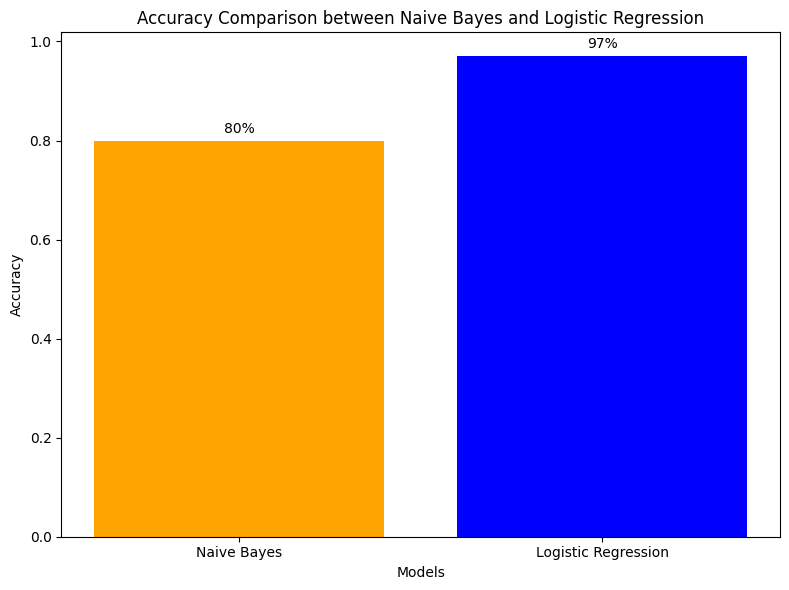

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have accuracy values from your model evaluation
accuracy_nb = 0.80  # 80% accuracy for Naive Bayes (replace with your calculated accuracy)
accuracy_lr = 0.97  # 97% accuracy for Logistic Regression (replace with your calculated accuracy)

# Accuracy scores for both models
accuracy_scores = [accuracy_nb, accuracy_lr]
models = ['Naive Bayes', 'Logistic Regression']

# Create the bar graph for Accuracy Comparison
plt.figure(figsize=(8, 6))
plt.bar(models, accuracy_scores, color=['orange', 'blue'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison between Naive Bayes and Logistic Regression')

# Display the accuracy values as percentages on top of the bars
for i, v in enumerate(accuracy_scores):
    plt.text(i, v + 0.01, f"{v*100:.0f}%", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
